> This notebook is meant to show a prototype for basic sentiment analysis with deep learning. Only the basics of preprocessing and architecture are tested. Test subsets of the data are used here only due to the more managable size as a proof of concept.

---

# Setup

##### Imports

In [97]:
import os

import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

##### Set Root Dir as CWD

In [2]:
# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


# Load

In [65]:
num_samples = 50_000

In [66]:
path = "data/yelp/reviews/"

In [67]:
%%time
# Load dev set (10% of total data) as train
train = pd.read_pickle(path + "dev.xz").iloc[:num_samples]

CPU times: total: 4.03 s
Wall time: 4.04 s


In [68]:
%%time
# Load test set (10% of total data) as test
test = pd.read_pickle(path + "test.xz").iloc[:num_samples]

CPU times: total: 3.86 s
Wall time: 3.85 s


In [69]:
train

,text,stars
6211529,They are really professional and always sugges...,5
2795691,This is my new favourite sushi restaurant in E...,4
4040968,Fantastic visit here. Hapoy to find it on my a...,5
870450,I have eaten here on a few occasions. There is...,3
5479481,This place is a disgrace. Their customer servi...,1
...,...,...
890129,The positive about this place is that it is ve...,2
2441141,Don't judge a book by its cover. Looks like a ...,5
1986611,Walked in two different times and the worker h...,1
4433516,Love the clam chowder.. the best in town. The ...,5


##### Save Target

In [70]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(train["stars"].values - 1)

# Preprocess

##### Create Pipeline

In [71]:
# Requires download
#   $ python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser"])

In [72]:
print(nlp.analyze_pipes(pretty=True))


============================= Pipeline Overview =============================

#   Component         Assigns          Requires   Scores          Retokenizes
-   ---------------   --------------   --------   -------------   -----------
0   tok2vec           doc.tensor                                  False      
                                                                             
1   tagger            token.tag                   tag_acc         False      
                                                                             
2   attribute_ruler                                               False      
                                                                             
3   lemmatizer        token.lemma                 lemma_acc       False      
                                                                             
4   ner               doc.ents                    ents_f          False      
                      token.ent_iob               ents_p      

In [73]:
i = 9

# Get a single sentence as an example
example = [test["text"].iloc[i]]

# Create a spacy doc with the example
example_doc = list(nlp.pipe(example))[0]
print(example_doc)

Great prices and a fabulous team to help with all your fabric needs! I've especially enjoyed working with the owner Kathy! Beautiful cushions, valances, drapes, and pillows!


In [74]:
# Tokenization example
for token in example_doc:
    print("[" + token.text + "]", end="")

[Great][prices][and][a][fabulous][team][to][help][with][all][your][fabric][needs][!][I]['ve][especially][enjoyed][working][with][the][owner][Kathy][!][Beautiful][cushions][,][valances][,][drapes][,][and][pillows][!]

In [75]:
for token in example_doc:
    # Print text, simple POS, detailed POS, shape, whether alphabetical, whether stopword
    print("[", token.text, token.lemma_, token.pos_, token.tag_,
          token.shape_, token.is_alpha, token.is_stop, "]", end="")

[ Great great ADJ JJ Xxxxx True False ][ prices price NOUN NNS xxxx True False ][ and and CCONJ CC xxx True True ][ a a DET DT x True True ][ fabulous fabulous ADJ JJ xxxx True False ][ team team NOUN NN xxxx True False ][ to to PART TO xx True True ][ help help VERB VB xxxx True False ][ with with ADP IN xxxx True True ][ all all DET DT xxx True True ][ your your PRON PRP$ xxxx True True ][ fabric fabric NOUN NN xxxx True False ][ needs need NOUN NNS xxxx True False ][ ! ! PUNCT . ! False False ][ I I PRON PRP X True True ][ 've 've AUX VBP 'xx False True ][ especially especially ADV RB xxxx True False ][ enjoyed enjoy VERB VBN xxxx True False ][ working work VERB VBG xxxx True False ][ with with ADP IN xxxx True True ][ the the DET DT xxx True True ][ owner owner NOUN NN xxxx True False ][ Kathy Kathy PROPN NNP Xxxxx True False ][ ! ! PUNCT . ! False False ][ Beautiful beautiful ADJ JJ Xxxxx True False ][ cushions cushion NOUN NNS xxxx True False ][ , , PUNCT , , False False ][ valan

In [76]:
# Named entity recognition
for ent in example_doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Kathy 116 121 PERSON


##### Perform Preprocessing

In [77]:
def normalize(doc):
    """Preprocesses a spacy Doc.
    
    Currently tokenizes, lemmatizes, and removes stopwords
    """
    output = list()
    for token in doc:
        if not token.is_stop and token.is_alpha:
            output.append(str(token.lemma_))
    
    return output

In [78]:
def apply_normalize(docs, batch_size=1_000, n_processes=1):
    """Applies preprocessing steps to iterable of spacy Docs."""
    results = []
    for doc in nlp.pipe(docs, n_process=n_processes):
        results.append(normalize(doc))
    return results

In [79]:
%%time
# Lowercase
X_train = train["text"].str.lower()
X_test = test["text"].str.lower()

# Set multiprocessing params
batch_size = 2000
n_processes = 4

# Preprocess reviews
X_train = apply_normalize(X_train, batch_size=batch_size, n_processes=n_processes)
X_test = apply_normalize(X_test, batch_size=batch_size, n_processes=n_processes)

CPU times: total: 59.5 s
Wall time: 3min 12s


In [80]:
maxlen = 200  # Number of words in review to consider

# Convert lists of words to vectors of numbers
tokenizer = keras.preprocessing.text.Tokenizer(maxlen)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sentences to be the same length
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

# Convert to tensors for Keras
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Embedding Layer Definition

In [81]:
class TokenAndPositionEmbedding(layers.Layer):
    """Pre-transformer embedding layer."""
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)

        x = self.token_emb(x)
        return x + positions

##### Transformer Layer Definition

In [82]:
class TransformerBlock(layers.Layer):
    """Transformer for further embedding."""
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        
        # Attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        # Feed-forward network
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        
        # Speed and regularization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Calculate attention and get output
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

##### Create Model

In [83]:
vocab_size = 20000  # Only consider the top 20k words
embed_dim = 32      # Embedding size for each token
num_heads = 2       # Number of attention heads
ff_dim = 32         # Hidden layer size in feed forward network inside transformer

# Input layer with max number of words
inputs = layers.Input(shape=(maxlen,))

# Add embedding layer
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Add transformer
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

# Additional layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)

# Output (5 possible categories for each star)
outputs = layers.Dense(5, activation="softmax")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

In [84]:
# Example outputs (probabilities of each star rating)
model.predict([X_train[:10]])

1/1 [==============================] - 0s 80ms/step


array([[0.13115484, 0.10596244, 0.20794629, 0.31744653, 0.23748994],
       [0.1354888 , 0.10805253, 0.22072366, 0.31056434, 0.22517076],
       [0.13541354, 0.1134186 , 0.2231145 , 0.30486146, 0.22319187],
       [0.1402655 , 0.11144646, 0.21823266, 0.30289194, 0.22716345],
       [0.13067488, 0.1086385 , 0.22442277, 0.31097046, 0.22529334],
       [0.13791656, 0.10886549, 0.2179352 , 0.30943426, 0.22584853],
       [0.14092946, 0.11099929, 0.21846907, 0.30470508, 0.22489707],
       [0.13287424, 0.10965152, 0.21901447, 0.30666658, 0.2317932 ],
       [0.13140863, 0.10730036, 0.21400109, 0.3141678 , 0.23312214],
       [0.147871  , 0.12313591, 0.22871847, 0.283249  , 0.21702568]],
      dtype=float32)

##### Compile and Run

In [85]:
%%time
# Compile and train model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test)
)

Epoch 1/100
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1073 - accuracy: 0.5588 - val_loss: 2.1961 - val_accuracy: 0.3421
Epoch 2/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0097 - accuracy: 0.5953 - val_loss: 2.0269 - val_accuracy: 0.3511
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9999 - accuracy: 0.5985 - val_loss: 2.1565 - val_accuracy: 0.3611
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9965 - accuracy: 0.5992 - val_loss: 2.2316 - val_accuracy: 0.3425
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9939 - accuracy: 0.6003 - val_loss: 2.1330 - val_accuracy: 0.3529
Epoch 6/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9900 - accuracy: 0.6007 - val_loss: 2.1664 - val_accuracy: 0.3561
Epoch 7/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9871 - accuracy: 0.6015 - val_loss: 2.1195 -

Epoch 57/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9176 - accuracy: 0.6242 - val_loss: 2.5163 - val_accuracy: 0.3354
Epoch 58/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9182 - accuracy: 0.6249 - val_loss: 2.3810 - val_accuracy: 0.3474
Epoch 59/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9159 - accuracy: 0.6262 - val_loss: 2.5459 - val_accuracy: 0.3311
Epoch 60/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9147 - accuracy: 0.6251 - val_loss: 2.4755 - val_accuracy: 0.3482
Epoch 61/100
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9132 - accuracy: 0.6261 - val_loss: 2.5911 - val_accuracy: 0.3328
Epoch 62/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9119 - accuracy: 0.6270 - val_loss: 2.4474 - val_accuracy: 0.3332
Epoch 63/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9112 - accuracy: 0.6276 - val_loss: 2.5

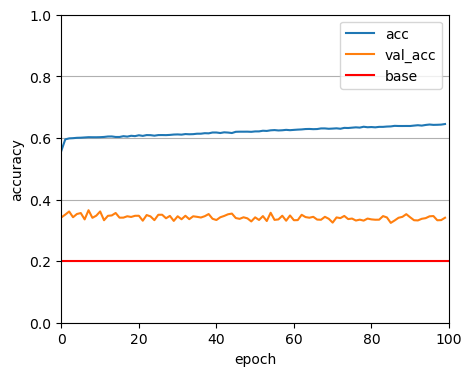

In [106]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

plt.figure(figsize=(5, 4), dpi=100)
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.axhline(0.2, color="red", label="base")
plt.xlim(0, 100)
plt.ylim(0.0, 1.0)
plt.grid(axis="y")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

> Little optimization appears to be happening here that does not result in overfitting.

##### Test

In [89]:
# Get probabilities per class
y_pred = model.predict(X_test)

1563/1563 [==============================] - 3s 2ms/step


In [90]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [107]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to 0.2)")

multi-class accuracy: 0.3409
compare to 0.2


In [108]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to 0.5)")

binary accuracy: 0.58012
(compare to 0.5)


# Summary

> While a preprocessing pipeline and classifier have been successfully established and employed, the results are far from ideal. Methods of improvement include employing more data, further experimenation with preprocessing methods such as NER, and improving the network architecture.